In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pygame
import time
import gymnasium as gym
from gymnasium.spaces import Dict, Discrete, Box
from collections import OrderedDict

import os 
import sys

sys.path.append(os.path.abspath('../..'))

from environment.env import ObservableDeformedGridworld
from utils.checkpoints import find_last_checkpoint


pygame 2.6.1 (SDL 2.28.4, Python 3.11.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


# env tests

In [2]:
def bounding_rectangle(vertices):
    """
    Computes the bounding rectangle for a quadrilateral.
    
    Parameters:
        vertices (list of tuples): Vertices of the quadrilateral.
    
    Returns:
        list of tuples: Vertices of the bounding rectangle.
    """
    x_coords = [v[0] for v in vertices]
    y_coords = [v[1] for v in vertices]
    xmin, xmax = min(x_coords), max(x_coords)
    ymin, ymax = min(y_coords), max(y_coords)
    
    return [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]

def is_point_in_triangle(point, triangle):
    """
    Check if a point is inside a triangle using barycentric coordinates.
    
    Args:
        point (tuple): (x, y) coordinates of the point to check
        triangle (list): List of 3 tuples, each representing vertex coordinates [(x1,y1), (x2,y2), (x3,y3)]
    
    Returns:
        bool: True if point is inside the triangle, False otherwise
    """
    def compute_barycentric_coordinates(pt, v1, v2, v3):
        """
        Compute barycentric coordinates of a point with respect to a triangle.
        
        Args:
            pt (tuple): Point coordinates
            v1, v2, v3 (tuple): Vertex coordinates of the triangle
        
        Returns:
            tuple: Barycentric coordinates (u, v, w)
        """
        pt = np.array(pt)
        v1, v2, v3 = np.array(v1), np.array(v2), np.array(v3)
        
        # Vectorized area computation
        triangle_area = np.abs(np.cross(v2 - v1, v3 - v1)) / 2
        
        # Areas of sub-triangles
        area1 = np.abs(np.cross(pt - v2, v3 - v2)) / 2
        area2 = np.abs(np.cross(v1 - pt, v3 - v1)) / 2
        area3 = np.abs(np.cross(v1 - v2, pt - v2)) / 2
        
        # Compute barycentric coordinates
        u = area1 / triangle_area
        v = area2 / triangle_area
        w = area3 / triangle_area
        
        return u, v, w
    
    # Compute barycentric coordinates
    u, v, w = compute_barycentric_coordinates(point, triangle[0], triangle[1], triangle[2])
    
    # Point is inside if all barycentric coordinates are between 0 and 1 (inclusive)
    return 0 <= u <= 1 and 0 <= v <= 1 and 0 <= w <= 1 and np.abs(u + v + w - 1) < 1e-10

def is_point_in_parallelogram(point, box):
    """
    Check if a point is inside a parallelogram.
    
    Args:
        point (tuple): (x, y) coordinates of the point to check
        box (list): List of 4 tuples, each representing vertex coordinates [(x1,y1), (x2,y2), (x3,y3), (x4,y4)]
    
    Returns:
        bool: True if point is inside the parallelogram, False otherwise
    """
    # Check if the point is in one of the two triangles of the parallelogram
    return is_point_in_triangle(point, [box[0], box[1], box[2]]) or is_point_in_triangle(point, [box[0], box[2], box[3]])

def sample_in_parallelogram(box):
    """
    Sample a point uniformly inside a parallelogram.
    
    Args:
        box (list): List of 4 tuples, each representing vertex coordinates [(x1,y1), (x2,y2), (x3,y3), (x4,y4)]
    
    Returns:
        tuple: (x, y) coordinates of the sampled point
    """

    # Compute bounding box
    rect = bounding_rectangle(box)
    x_min, y_min = rect[0]
    x_max, y_max = rect[2]    
    # Keep sampling until a point inside the parallelogram is found

    x = np.random.uniform(x_min, x_max)
    y = np.random.uniform(y_min, y_max)
    while not is_point_in_parallelogram((x, y), box):
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(y_min, y_max)
    
    return [x, y]

Point: [0.45388612 0.95050459]
Box: [array([0., 0.]), array([0.55654792, 0.14692519]), array([0.53335694, 1.08853905]), array([-0.02319099,  0.94161386])]
True


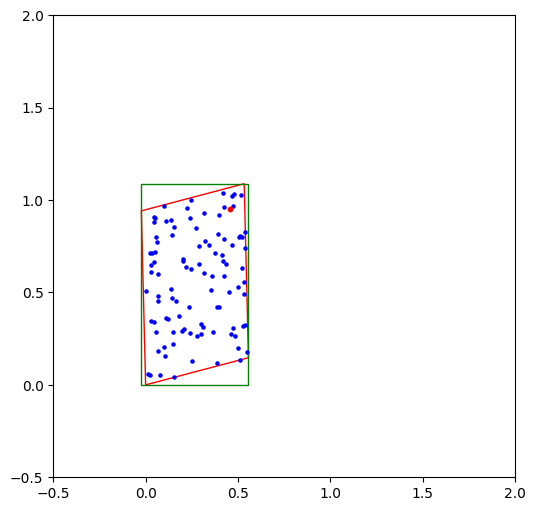

In [31]:
point = env.state
box = env.transformed_corners

print("Point:", point)
print("Box:", box)

print(is_point_in_parallelogram(point, box))

# sample 100 points in the parallelogram and plot them along with the parallelogram
points = [sample_in_parallelogram(box) for _ in range(100)]
points = np.array(points)
# box = [(0, 0), (2, 1), (3, 2), (1, 1)]
rectangle = bounding_rectangle(box)
plt.figure(figsize=(6, 6))
plt.gca().add_patch(patches.Polygon(box, fill=None, edgecolor='r'))
plt.gca().add_patch(patches.Polygon(rectangle, fill=None, edgecolor='g'))
plt.scatter(points[:, 0], points[:, 1], c='b', s=5)
plt.scatter(point[0], point[1], c='r', s=10)
plt.xlim(-.5, 2)
plt.ylim(-.5, 2)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
class ObservableDeformedGridworld(gym.Env):

    def __init__(self, grid_size=(1.0, 1.0), step_size=0.02, goal=(0.9, 0.9), 
                 obstacles=None, stretch=(1.0, 1.0), shear=(0.0, 0.0), observation_radius=0.05, render_mode=None,shear_range=(-0.2,0.2),stretch_range=(0.4,1),max_timesteps=500):
        """
        Initialize the observable deformed continuous gridworld.
        :param grid_size: Size of the grid (width, height).
        :param step_size: Step size for the agent's movement.
        :param goal: Coordinates of the goal position.
        :param obstacles: List of obstacles as rectangles [(x_min, y_min), (x_max, y_max)].
        :param stretch: Tuple (s_x, s_y) for stretching the grid in x and y directions.
        :param shear: Tuple (sh_x, sh_y) for shearing the grid.
        :param observation_radius: Radius within which the agent can observe its surroundings.
        """
        self.grid_size = np.array(grid_size)
        self.step_size = step_size
        self.goal = np.array(goal)
        self.state = np.array([0.1, 0.1])  # Start at the origin
        self.obstacles = obstacles if obstacles else []
        self.observation_radius = observation_radius

        # Transformation matrix
        self.transformation_matrix = np.array([
            [stretch[0], shear[0]],
            [shear[1], stretch[1]]
        ])
        self.inverse_transformation_matrix = np.linalg.inv(self.transformation_matrix)

        # Rendering mode
        self.render_mode = render_mode

        # gymnasium compatibility
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space =  Dict({
            "pos": gym.spaces.Box(low=.0, high=1.0, shape=(2,),dtype=float),
            "theta": gym.spaces.Box(low=.0, high=1.0, shape=(4,),dtype=float), # deformation is a 2x2 tensor
        })

        self.stretch_range = stretch_range
        self.shear_range = shear_range
        self.max_timesteps = max_timesteps

        self.timestep = 0

        self.corners = [
            np.array([0, 0]),
            np.array([self.grid_size[0], 0]),
            self.grid_size,
            np.array([0, self.grid_size[1]]),
        ]
        self.transformed_corners = [self.transform(corner) for corner in self.corners]
        
    def reset(self,seed=None):
        """
        Reset the environment to the initial state.
        :return: Initial state and observation.
        """
        np.random.seed(seed)
        self.set_deformation(self.sample(2,self.stretch_range), self.sample(2,self.shear_range))  # Reset deformation to random
        self.transformed_corners = [self.transform(corner) for corner in self.corners]
        # self.state = np.array([0.1, 0.1])  # Start at the origin
        #self.state = np.random.rand(2) * self.transform(self.grid_size) # Random start position in the deformable grid
        self.state = sample_in_parallelogram(self.transformed_corners)


        state = OrderedDict({
            "pos": self.state,
            "theta": self.transformation_matrix.flatten(),
        }) 
        
        self.timestep = 0

        # print(f"Initial agent position: {self.state}",
        #       f"Initial goal position: {self.goal}",
        #       f"Initial deformation: {self.transformation_matrix}",
        #       f"Initial observation: {self.observe_obstacle()}",
        #       sep="\n")
        
        return state, {}
    
    def set_deformation(self, stretch, shear):
        """
        Set the deformation transformation matrix based on stretch and shear parameters.
        
        This function creates a transformation matrix to apply grid deformations, including 
        stretching and shearing, to the grid coordinates. It also computes the inverse of 
        this transformation for reversing the deformation.

        :param stretch: A tuple (s_x, s_y) for stretching the grid in the x and y directions.
        :param shear: A tuple (sh_x, sh_y) for shearing the grid in the x and y directions.
        """
        # Create the transformation matrix based on stretch and shear
        self.transformation_matrix = np.array([
            [stretch[0], shear[0]],  # First row: stretch in x and shear in x direction
            [shear[1], stretch[1]]   # Second row: shear in y and stretch in y direction
        ])

        # Calculate the inverse transformation matrix for reversing the deformation
        self.inverse_transformation_matrix = np.linalg.inv(self.transformation_matrix)

        # Optionally, print the transformation matrices for debugging
        # print(f"Transformation Matrix:\n{self.transformation_matrix}")
        # print(f"Inverse Transformation Matrix:\n{self.inverse_transformation_matrix}")

    def set_pos(self, pos):
        """
        Set the agent's state to a new position.
        
        This function directly updates the agent's position (state) to the provided coordinates.

        :param pos: A tuple or array representing the new position of the agent in the grid.
        """
        # Update the state (agent's position)
        self.state = np.array(pos)

        # Optionally, print the new state for debugging
        # print(f"New agent position: {self.state}")

    def transform(self, position):
        """
        Apply the grid deformation to a given position.
        :param position: (x, y) in original space.
        :return: Transformed position in the deformed grid.
        """
        return np.dot(self.transformation_matrix, position)

    def inverse_transform(self, position):
        """
        Map a position from the deformed grid back to the original space.
        :param position: (x, y) in the deformed grid.
        :return: Original position.
        """
        return np.dot(self.inverse_transformation_matrix, position)
    
    def is_in_obstacle(self, position):
        """
        Check if a given position is inside any obstacle.
        :param position: The (x, y) coordinates to check in the original space.
        :return: True if the position is inside an obstacle, False otherwise.
        """
        for obs in self.obstacles:
            (x_min, y_min), (x_max, y_max) = obs
            bottom_left = self.transform(np.array([x_min, y_min]))
            bottom_right = self.transform(np.array([x_max, y_min]))
            top_left = self.transform(np.array([x_min, y_max]))
            top_right = self.transform(np.array([x_max, y_max]))
            obstacle = [bottom_left, bottom_right, top_right, top_left]
            if is_point_in_parallelogram(position, obstacle):
                return True
        return False
    
    def observe_obstacle_rectangle(self):
        """
        Efficiently and precisely check for obstacles in the four cardinal directions (N, E, S, W).
        Each direction checks for obstacles in a quarter-circle arc within the observation radius.
        :return: A numpy array of shape (4,), where each entry indicates the presence of obstacles 
                in the respective direction (North, East, South, West).
        """
        directions = ["N", "E", "S", "W"]
        obstacle_presence = np.zeros(4)  # Default: no obstacles in any direction

        # Precompute direction boundaries in radians
        direction_ranges = [
            (315, 45),   # North: [-45°, +45°]
            (45, 135),   # East: [+45°, +135°]
            (135, 225),  # South: [+135°, +225°]
            (225, 315)   # West: [+225°, +315°]
        ]
        direction_ranges_rad = [(np.deg2rad(a1), np.deg2rad(a2)) for a1, a2 in direction_ranges]

        for obs in self.obstacles:
            (x_min, y_min), (x_max, y_max) = obs
            x_min, y_min = self.transform([x_min, y_min])
            x_max, y_max = self.transform([x_max, y_max])

            # Generate sampled points along the edges of the obstacle
            num_samples = 5  # Increase for more precision
            edge_points = np.concatenate([
                np.linspace([x_min, y_min], [x_max, y_min], num_samples),  # Bottom edge
                np.linspace([x_max, y_min], [x_max, y_max], num_samples),  # Right edge
                np.linspace([x_max, y_max], [x_min, y_max], num_samples),  # Top edge
                np.linspace([x_min, y_max], [x_min, y_min], num_samples)   # Left edge
            ])

            # Compute vectors from agent to sampled points
            vectors = edge_points - self.state
            distances = np.linalg.norm(vectors, axis=1)

            # Filter points that are outside the observation radius
            within_radius = distances <= self.observation_radius
            if not np.any(within_radius):
                continue  # Skip obstacles entirely outside the radius

            # Compute angles relative to positive Y-axis
            angles = np.arctan2(vectors[:, 1], vectors[:, 0])  # Radians
            angles = (angles + 2 * np.pi) % (2 * np.pi)  # Normalize to [0, 2π)

            # Check which direction each point falls into
            for i, (angle_min, angle_max) in enumerate(direction_ranges_rad):
                if obstacle_presence[i] == 1:
                    continue  # Early exit if the direction is already flagged
                for angle in angles[within_radius]:
                    if (angle_min <= angle < angle_max) or (
                        angle_max < angle_min and (angle >= angle_min or angle < angle_max)
                    ):
                        obstacle_presence[i] = 1
                        break  # No need to check further points for this direction

        return obstacle_presence
        
    def step(self, action):
        """
        Take a step in the environment, interpreting the action in the deformed space.
        :param action: One of ['N', 'S', 'E', 'W'].
        :return: Tuple (next_state, observation, reward, done, info).
        """
        # Map actions to movements in the deformed space
        moves = [np.array([0, self.step_size]),   # Move up in deformed space
            np.array([0, -self.step_size]),  # Move down in deformed space
            np.array([self.step_size, 0]),   # Move right in deformed space
            np.array([-self.step_size, 0])   # Move left in deformed space
        ]

        # Get the movement vector in the deformed space
        move = moves[action]

        # Map the movement to the original space using the inverse transformation
        # move_original = np.dot(self.inverse_transformation_matrix, move)

        # Update state in the original grid space
        next_state = self.state + move

        num_samples = 10  # Number of points to sample along the path
        path = np.linspace(self.state, next_state, num_samples)

        # Check for collisions along the path
        collision = any(self.is_in_obstacle(point) for point in path)

        # Check if the new state is in an obstacle
        if np.linalg.norm(next_state - self.transform(self.goal)) < self.observation_radius:
            terminated = True
            reward = 1.0 
            info = {"collision": False, "out": False, 'goal': True}
        # Check if the is inside the deformed grid boundaries
        elif not is_point_in_parallelogram(next_state, self.transformed_corners):
            reward = -2.0
            info = {"out": True}
            next_state = self.state
            terminated = False
        elif collision:   
            reward = -2.0  # Penalty for hitting an obstacle
            info = {"collision": True}
            terminated = False
        else:
            terminated = False
            reward = -0.5
            info = {"collision": False, "out": False, "goal": False}
    
        self.state = next_state
        self.timestep += 1
        truncated = self.timestep > self.max_timesteps 

        if self.render_mode == "human":
            self.render()

        state = OrderedDict({
                    "pos": self.state,
                    "theta": self.transformation_matrix.flatten(),
                })

        # Return the transformed state, reward, and terminated truncated flag
        return state, reward, terminated, truncated, info

    def render_old(self):
        """
        Render the deformed gridworld environment using Pygame, ensuring the entire deformed grid fits within the screen.
        """
        import pygame  # Ensure Pygame is imported

        # Define colors
        WHITE = (255, 255, 255)
        BLUE = (0, 0, 255)
        GREEN = (0, 255, 0)
        RED = (255, 0, 0)
        YELLOW = (255, 255, 0)
        BLACK = (0, 0, 0)

        # Initialize the screen
        if not hasattr(self, "screen"):
            self.screen_width = 800
            self.screen_height = 600
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            pygame.display.set_caption("Deformed Gridworld Environment")

        # Fill background with white
        self.screen.fill(WHITE)

        # Compute the bounding box of the deformed grid
        corners = [
            self.transform(np.array([0, 0])),
            self.transform(np.array([self.grid_size[0], 0])),
            self.transform(self.grid_size),
            self.transform(np.array([0, self.grid_size[1]])),
        ]
        x_coords, y_coords = zip(*corners)
        min_x, max_x = min(x_coords), max(x_coords)
        min_y, max_y = min(y_coords), max(y_coords)

        # Define scaling factors to fit the deformed grid within the screen
        scale_x = self.screen_width / (max_x - min_x)
        scale_y = self.screen_height / (max_y - min_y)
        scale = min(scale_x, scale_y)  # Uniform scaling to maintain aspect ratio

        # Transform helper for rendering
        def to_screen_coords(pos):
            """
            Map transformed coordinates to screen coordinates, scaled and shifted to fit the screen.
            """
            x, y = pos
            x_screen = int((x - min_x) * scale)
            y_screen = int((max_y - y) * scale)  # Flip y-axis for screen rendering
            return x_screen, y_screen

        # Draw the deformed grid boundaries
        pygame.draw.polygon(self.screen, BLACK, [to_screen_coords(corner) for corner in corners], width=3)

        # Draw the obstacles
        for obs in self.obstacles:
            (x_min, y_min), (x_max, y_max) = obs
            bottom_left = self.transform(np.array([x_min, y_min]))
            bottom_right = self.transform(np.array([x_max, y_min]))
            top_left = self.transform(np.array([x_min, y_max]))
            top_right = self.transform(np.array([x_max, y_max]))
            
            # Draw each obstacle as a polygon in the deformed space
            pygame.draw.polygon(self.screen, RED, [
                to_screen_coords(bottom_left),
                to_screen_coords(bottom_right),
                to_screen_coords(top_right),
                to_screen_coords(top_left)
            ])

        # Draw the agent
        agent_position = self.transform(self.state)
        pygame.draw.circle(self
        .screen, BLUE, to_screen_coords(agent_position), 10)

        # Draw the goal
        goal_position = self.transform(self.goal)
        pygame.draw.circle(self.screen, GREEN, to_screen_coords(goal_position), 12)

        # Draw observation radius as a dashed circle around the agent
        observation_radius = self.observation_radius * max(self.transformation_matrix.diagonal())
        pygame.draw.circle(self.screen, YELLOW, to_screen_coords(agent_position), 
                        int(observation_radius * scale), 1)

        # Update the display
        pygame.display.flip()

        # Handle key events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                return
            elif event.type == pygame.KEYDOWN:
                # Press 'r' to reset environment
                if event.key == pygame.K_r:
                    self.reset()
                # Press 'w' to quit
                elif event.key == pygame.K_w:
                    pygame.quit()
                    return
                # Press 's' to save current state
                elif event.key == pygame.K_s:
                    self.save_state()
                # Press space to pause/resume
                elif event.key == pygame.K_SPACE:
                    self.pause()
                # Press arrow keys for manual control
                elif event.key == pygame.K_LEFT:
                    return self.step(3)  # Left action
                elif event.key == pygame.K_RIGHT:
                    return self.step(2)  # Right action
                elif event.key == pygame.K_UP:
                    return self.step(0)  # Up action
                elif event.key == pygame.K_DOWN:
                    return self.step(1)  # Down action
        return None, None, None, None, None
    
    def close(self):
        self.render_mode = None
        pygame.quit()
    
    def sample(self,num,limit):
        low,high = limit
        return low + np.random.rand(num)*(high-low)
    
    def render(self):
        """
        Render the deformed gridworld environment along with the original gridworld.
        The original gridworld serves as a reference background.
        """
        import pygame  # Ensure Pygame is imported

        # Define colors
        WHITE = (255, 255, 255)
        LIGHT_GRAY = (200, 200, 200)
        BLUE = (0, 0, 255)
        GREEN = (0, 255, 0)
        RED = (255, 0, 0)
        PINK = (255, 105, 180)  
        YELLOW = (255, 255, 0)
        BLACK = (0, 0, 0)

        # Initialize the screen
        if not hasattr(self, "screen"):
            self.screen_width = 1000
            self.screen_height = 1000
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            pygame.display.set_caption("Deformed and Original Gridworld")

        # Fill background with white
        self.screen.fill(WHITE)

    # Compute the bounding box of the deformed grid
        corners = [
            np.array([0, 0]),
            np.array([self.grid_size[0], 0]),
            self.grid_size,
            np.array([0, self.grid_size[1]]),
        ]
        transformed_corners = [self.transform(corner) for corner in corners]
        x_coords, y_coords = zip(*transformed_corners)
        min_x, max_x = min(x_coords), max(x_coords)
        min_y, max_y = min(y_coords), max(y_coords)

        # Define scaling factors to fit the deformed grid within the screen
        scale_x = self.screen_width / (max_x - min_x)
        scale_y = self.screen_height / (max_y - min_y)
        scale = min(scale_x, scale_y)  # Uniform scaling to maintain aspect ratio

        # Add upward translation offset
        y_translation = max(0, -min_y * scale)

        # Transform helper for rendering
        def to_screen_coords(pos):
            """
            Map transformed coordinates to screen coordinates, scaled and shifted to fit the screen.
            """
            x, y = pos
            x_screen = int((x - min_x) * scale)
            y_screen = int((max_y - y) * scale + y_translation)  # Flip y-axis and add upward translation
            return x_screen, y_screen
        
        # Draw the un-deformed grid (background)
        for i in range(int(self.grid_size[0]) + 1):
            pygame.draw.line(self.screen, LIGHT_GRAY,
                            to_screen_coords((i, 0)),
                            to_screen_coords((i, self.grid_size[1])), width=1)
        for j in range(int(self.grid_size[1]) + 1):
            pygame.draw.line(self.screen, LIGHT_GRAY,
                            to_screen_coords((0, j)),
                            to_screen_coords((self.grid_size[0], j)), width=1)

        # Draw the deformed grid boundaries
        corners = [
            np.array([0, 0]),
            np.array([self.grid_size[0], 0]),
            self.grid_size,
            np.array([0, self.grid_size[1]]),
        ]
        transformed_corners = [self.transform(corner) for corner in corners]
        pygame.draw.polygon(self.screen, BLACK, [to_screen_coords(corner) for corner in transformed_corners], width=3)

        # Draw the obstacles in both grids
        for obs in self.obstacles:
            (x_min, y_min), (x_max, y_max) = obs
            # Original obstacle
            pygame.draw.rect(self.screen, PINK,
                            (*to_screen_coords((x_min, y_max)),  # Top-left corner
                            int((x_max - x_min) * scale),      # Width
                            int((y_max - y_min) * scale)),    # Height
                            width=0)

            # Transformed obstacle
            bottom_left = self.transform(np.array([x_min, y_min]))
            bottom_right = self.transform(np.array([x_max, y_min]))
            top_left = self.transform(np.array([x_min, y_max]))
            top_right = self.transform(np.array([x_max, y_max]))
            pygame.draw.polygon(self.screen, RED, [
                to_screen_coords(bottom_left),
                to_screen_coords(bottom_right),
                to_screen_coords(top_right),
                to_screen_coords(top_left)
            ])

        # Draw the agent in both grids
        agent_position = self.state
        transformed_agent_position = agent_position
        pygame.draw.circle(self.screen, BLUE, to_screen_coords(agent_position), 10)  # Original
        pygame.draw.circle(self.screen, GREEN, to_screen_coords(transformed_agent_position), 10)  # Transformed

        # Draw the goal in both grids
        goal_position = self.goal
        transformed_goal_position = self.transform(goal_position)
        pygame.draw.circle(self.screen, GREEN, to_screen_coords(goal_position), 12)  # Original
        pygame.draw.circle(self.screen, YELLOW, to_screen_coords(transformed_goal_position), 12)  # Transformed

        # Draw observation radius as a dashed circle around the agent
        observation_radius = self.observation_radius # stays the same in both grids
        pygame.draw.circle(self.screen, YELLOW, to_screen_coords(agent_position), 
                        int(self.observation_radius * scale), 1)  # Original
        pygame.draw.circle(self.screen, YELLOW, to_screen_coords(transformed_agent_position), 
                        int(observation_radius * scale), 1)  # Transformed

        # Update the display
        pygame.display.flip()

        # Handle key events
        # Handle key events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                return
            elif event.type == pygame.KEYDOWN:
                # Press 'r' to reset environment
                if event.key == pygame.K_r:
                    self.reset()
                # Press 'w' to quit
                elif event.key == pygame.K_w:
                    pygame.quit()
                    return
                # Press 's' to save current state
                elif event.key == pygame.K_s:
                    self.save_state()
                # Press space to pause/resume
                elif event.key == pygame.K_SPACE:
                    self.pause()
                # Press arrow keys for manual control
                elif event.key == pygame.K_LEFT:
                    return self.step(3)  # Left action
                elif event.key == pygame.K_RIGHT:
                    return self.step(2)  # Right action
                elif event.key == pygame.K_UP:
                    return self.step(0)  # Up action
                elif event.key == pygame.K_DOWN:
                    return self.step(1)  # Down action
        return None, None, None, None, None

    def set_pos_nodeform(self):
        """
        Set the agent's state to a new position.
        
        This function directly updates the agent's position (state) to the provided coordinates.

        :param pos: A tuple or array representing the new position of the agent in the grid.
        """
        low, high = -.2, 1.2 # depends on the shear (nto stretch since compression)
        pos = self.sample(2,limit=(low,high))
        
        # Update the state (agent's position)
        self.state = np.array(pos)

        # Optionally, print the new state for debugging
        # print(f"New agent position: {self.state}")

        return pos
    def is_in_obstacle_nodeform(self, position):
        """
        Check if a given position is inside any obstacle.
        :param position: The (x, y) coordinates to check in the original space.
        :return: True if the position is inside an obstacle, False otherwise.
        """
        for obs in self.obstacles:
            (x_min, y_min), (x_max, y_max) = obs
            if x_min <= position[0] <= x_max and y_min <= position[1] <= y_max:            
                return True
        return False



In [52]:
obstacles = [((0.14625, 0.3325), (0.565, 0.55625)), 
             ((0.52875, 0.5375), (0.7375, 0.84125)), 
             ((0.0, 0.00125), (0.01625, 0.99125)), 
             ((0.0075, 0.00125), (0.99875, 0.04)), 
             ((0.98875, 0.0075), (0.99875, 1.0)), 
             ((0.00125, 0.9825), (0.99875, 1.0))]

# Example Usage
# obstacles = [
#     [(0.2, 0.2), (0.6, 0.6)],  # Obstacle 1
#     [(0.6, 0.6), (0.8, 0.8)]   # Obstacle 2
# ]

env = ObservableDeformedGridworld(
    obstacles=obstacles, 
    stretch=(.5, 1),
    shear=(.2, .2),
    render_mode="human"
)

# state, observation = env.reset(np.random.randint(100))
#   
# env.reset(seed=np.random.randint(1078890))
done = False
while not done:
    try:
        _, reward, terminated, truncated, _ = env.render()
        if terminated or truncated:
            print(reward)
            env.close()
            break
    except:
        break



In [18]:
((0.14625, 0.3325), (0.565, 0.55625)),

(((0.14625, 0.3325), (0.565, 0.55625)),)

In [17]:
for i in range(100):
    state, observation = env.reset(np.random.randint(100))
    env.set_pos(env.transform([0.9,0.9]))
    assert np.linalg.norm(env.state - env.transform(env.goal)) < env.observation_radius


# train

In [4]:
from stable_baselines3 import DQN
run_id = "n82b50oj"

last_check = find_last_checkpoint(f"../agents/pretrained/MDP/DQN_continous_{run_id}")

obstacles = [((0.14625, 0.3325), (0.565, 0.55625)), 
             ((0.52875, 0.5375), (0.7375, 0.84125)), 
             ((0.0, 0.00125), (0.01625, 0.99125)), 
             ((0.0075, 0.00125), (0.99875, 0.04)), 
             ((0.98875, 0.0075), (0.99875, 1.0)), 
             ((0.00125, 0.9825), (0.99875, 1.0))]

env = ObservableDeformedGridworld(
    obstacles=obstacles, 
    stretch=(.5, 1),
    shear=(.2, .2),
    render_mode="human"
)
model = DQN.load(f"../agents/pretrained/MDP/DQN_continous_{run_id}/{last_check}", env=env)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [11]:
model.rollout_buffer.sample(382)

AttributeError: 'DQN' object has no attribute 'rollout_buffer'

In [ ]:
from stable_baselines3 import DQN
import numpy as np
import os
import re


obstacles = [((0.14625, 0.3325), (0.565, 0.55625)), 
             ((0.52875, 0.5375), (0.7375, 0.84125)), 
             ((0.0, 0.00125), (0.01625, 0.99125)), 
             ((0.0075, 0.00125), (0.99875, 0.04)), 
             ((0.98875, 0.0075), (0.99875, 1.0)), 
             ((0.00125, 0.9825), (0.99875, 1.0))]

import os
import re

def find_last_checkpoint(directory):
    # Define the regex pattern to match the checkpoint file names
    pattern = re.compile(r"rl_model_(\d+)_steps")

    last_checkpoint = None
    max_steps = -1

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            # Extract the step number
            steps = int(match.group(1))
            # Check if this is the highest step count seen so far
            if steps > max_steps:
                max_steps = steps
                last_checkpoint = filename

    return os.path.splitext(last_checkpoint)[0] if last_checkpoint else None


def train_dqn(args):
    from stable_baselines3.common.callbacks import CheckpointCallback
    from wandb.integration.sb3 import WandbCallback
    import wandb

    total_timesteps = args.total_timesteps
    batch_size = args.batch_size
    lr = args.learning_rate
    target_update = args.target_update
    gamma = args.gamma

    config = {
        "policy_type": "MultiInputPolicy",
        "env_name": "ObservableDeformedGridworld",
        "total_timesteps": total_timesteps,
        "Batch_Size": batch_size,
        'grid_size': (1.0,1.0),
        'step_size': 0.1,
        'obstacles':obstacles,
        'observation_radius':0.2,
    }

    if args.run_id is not None:
        run = wandb.init(
            project="DQNsb3 - MDP - ObservableDeformedGridworld",
            config=config,
            sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
            monitor_gym=True,  # auto-upload the videos of agents playing the game
            save_code=True,  # optional
            resume="must",
            id=args.run_id
        )
    else:
        run = wandb.init(
        project="DQNsb3 - MDP - ObservableDeformedGridworld",
        config=config,
        sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
        monitor_gym=True,  # auto-upload the videos of agents playing the game
        save_code=True,  # optional
        )


    # Save a checkpoint every 10000 steps
    checkpoint_callback = CheckpointCallback(
                            save_freq=10000,
                            save_path=f"DQN_continous_{run.id}",
                            name_prefix="rl_model",
                            save_replay_buffer=False,
                            save_vecnormalize=True,
                        )

    callbacks = [ WandbCallback(
                                verbose=2,
                                log="parameters",
                                ),
                checkpoint_callback,
                ]


    from stable_baselines3.common.monitor import Monitor
    from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder

    def make_env():
        env = ObservableDeformedGridworld(
            grid_size=(1.0, 1.0),
            obstacles=obstacles,
            render_mode='human'
        )

        env = Monitor(env)  # record stats such as returns
        return env

    env = DummyVecEnv([make_env])


    if args.run_id is not None:
        last_check = find_last_checkpoint(f"DQN_continous_{args.run_id}")
        model = DQN.load(last_check, env=env)
    else:
        net_arch=[128, 128, 128]
        model = DQN("MultiInputPolicy",env,batch_size=batch_size,gamma=gamma, 
                    target_update_interval=target_update, policy_kwargs=dict(net_arch=net_arch), verbose=1,
                    device="cpu", learning_rate=lr,
                    train_freq=(1,"episode"), gradient_steps=1)
        
    model.learn(total_timesteps,progress_bar=True, callback=callbacks, log_interval=1, reset_num_timesteps=False)
    model.save(f"agents/pretrained/MDP/DQN_continous_{run.id}")
    env.close()
    run.finish()

if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--learning_rate", type=float, default=0.001)
    parser.add_argument("--batch_size", type=int, default=64)
    parser.add_argument("--total_timesteps", type=int, default=1000000) # env steps
    parser.add_argument("--target_update", type=int, default=555) # in env steps
    parser.add_argument("--gamma", type=float, default=0.99)
    parser.add_argument("--f", type=str, default=None)
    parser.add_argument("--run_id", type=str, default="n82b50oj", help="wandb run id to resume from")

    args = parser.parse_args()

    train_dqn(args)

global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇████
rollout/ep_len_mean,▁▁▁▁▁▄▄▄▄▄▁▁▁▁▁███████
rollout/ep_rew_mean,██▆▆▆▄▄▄▅▅▇▇▇▇▇▂▂▂▁▁▁▁
rollout/exploration_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/fps,▁▅▇██▇▆▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▁▂█▃▃▃▇▅▅▂▁▂▁▁▁▁▁▂▂▅▅▁
global_step,760844
rollout/ep_len_mean,461.12
rollout/ep_rew_mean,-237.445
rollout/exploration_rate,0.05


FileNotFoundError: [Errno 2] No such file or directory: 'rl_model_760000_steps.zip.zip'

In [9]:
import os
import re

def find_last_checkpoint(directory):
    # Define the regex pattern to match the checkpoint file names
    pattern = re.compile(r"rl_model_(\d+)_steps")

    last_checkpoint = None
    max_steps = -1

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            # Extract the step number
            steps = int(match.group(1))
            # Check if this is the highest step count seen so far
            if steps > max_steps:
                max_steps = steps
                last_checkpoint = filename

    return os.path.splitext(last_checkpoint)[0] if last_checkpoint else None




In [10]:
last_check = find_last_checkpoint("DQN_continous_n82b50oj")
print(last_check)

#

rl_model_760000_steps


# eval

In [29]:
from stable_baselines3 import DQN

obstacles = [((0.14625, 0.3325), (0.565, 0.55625)), 
             ((0.52875, 0.5375), (0.7375, 0.84125)), 
             ((0.0, 0.00125), (0.01625, 0.99125)), 
             ((0.0075, 0.00125), (0.99875, 0.04)), 
             ((0.98875, 0.0075), (0.99875, 1.0)), 
             ((0.00125, 0.9825), (0.99875, 1.0))]

env = ObservableDeformedGridworld(
    obstacles=obstacles, 
    stretch=(.5, .5),
    shear=(.0, .0),
    render_mode="human"
)

net_arch=[128, 128, 128]
last_checkpoint = find_last_checkpoint("../agents/pretrained/MDP/DQN_continous_htpthl01")
model = DQN.load(f"../agents/pretrained/MDP/DQN_continous_htpthl01/{last_checkpoint}", env=env,  print_system_info=True)

env = ObservableDeformedGridworld(
    obstacles=obstacles, 
    stretch=(.5, .5),
    shear=(.0, .0),
    render_mode="human"
)

state, _ = env.reset(seed=np.random.randint(100))
env.set_deformation((1, 1), (.0, .0))
while True:
    action, _ = model.predict(state, deterministic=True)
    print(action)
    state, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        print(terminated, truncated)
        env.close()
        break
    # time.sleep(0.5)


== CURRENT SYSTEM INFO ==
- OS: Linux-6.11.2-amd64-x86_64-with-glibc2.40 # 1 SMP PREEMPT_DYNAMIC Kali 6.11.2-1kali1 (2024-10-15)
- Python: 3.11.10
- Stable-Baselines3: 2.4.0
- PyTorch: 2.5.1+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-6.10.3-200.fc40.x86_64-x86_64-with-glibc2.39 # 1 SMP PREEMPT_DYNAMIC Mon Aug  5 14:30:00 UTC 2024
- Python: 3.11.10
- Stable-Baselines3: 2.4.0
- PyTorch: 2.5.1+cu121
- GPU Enabled: False
- Numpy: 1.26.3
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
2
2
2
2
2
2
0
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


error: display Surface quit

In [2]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import DQN
from environment.env import Grid

obstacles = [((0.14625, 0.3325), (0.565, 0.55625)), 
             ((0.52875, 0.5375), (0.7375, 0.84125)), 
             ((0.0, 0.00125), (0.01625, 0.99125)), 
             ((0.0075, 0.00125), (0.99875, 0.04)), 
             ((0.98875, 0.0075), (0.99875, 1.0)), 
             ((0.00125, 0.9825), (0.99875, 1.0))]

env = Grid(
    obstacles=obstacles, 
    shear_range=(-.2, .2),
    stretch_range=(.4,1),
    render_mode="human"
)

last_checkpoint = find_last_checkpoint("../../agents/pretrained/MDP/DQN_continous_1vbmjd2a")
model = DQN.load(f"../../agents/pretrained/MDP/DQN_continous_1vbmjd2a/{last_checkpoint}", env=env)


mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20, deterministic=True)
print(mean_reward, std_reward)
env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/flaccagora/.miniconda3/envs/robogym/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


-119.95 118.70361199222202


# render


In [3]:
obstacles = [((0.14625, 0.3325), (0.565, 0.55625)), 
             ((0.52875, 0.5375), (0.7375, 0.84125)), ((0.0, 0.00125), (0.01625, 0.99125)), ((0.0075, 0.00125), (0.99875, 0.04)), ((0.98875, 0.0075), (0.99875, 1.0)), ((0.00125, 0.9825), (0.99875, 1.0))]

env = ObservableDeformedGridworld(
    obstacles=obstacles, 
    stretch=(1, 1),
    shear=(.0, .0),
    render_mode="human"
)

state, observation = env.reset(np.random.randint(1005647))
previous = None 
while True:
    try:
        state, reward, terminated, truncated, info = env.render()
        if state != previous:
            print(state,reward)
            previous = state  
        if terminated or truncated:
            print(terminated, truncated)
            env.close()
            break
    except:
        break




OrderedDict([('pos', array([ 0.40588055, -0.05670514])), ('theta', array([ 0.80373425, -0.0133121 , -0.19033908,  0.93468088]))]) -2.0
None None
OrderedDict([('pos', array([ 0.42588055, -0.05670514])), ('theta', array([ 0.80373425, -0.0133121 , -0.19033908,  0.93468088]))]) -0.5
None None
OrderedDict([('pos', array([ 0.42588055, -0.03670514])), ('theta', array([ 0.80373425, -0.0133121 , -0.19033908,  0.93468088]))]) -0.5
None None
OrderedDict([('pos', array([ 0.42588055, -0.01670514])), ('theta', array([ 0.80373425, -0.0133121 , -0.19033908,  0.93468088]))]) -0.5
None None
OrderedDict([('pos', array([0.42588055, 0.00329486])), ('theta', array([ 0.80373425, -0.0133121 , -0.19033908,  0.93468088]))]) -0.5
None None
OrderedDict([('pos', array([0.42588055, 0.02329486])), ('theta', array([ 0.80373425, -0.0133121 , -0.19033908,  0.93468088]))]) -0.5
None None
OrderedDict([('pos', array([0.42588055, 0.04329486])), ('theta', array([ 0.80373425, -0.0133121 , -0.19033908,  0.93468088]))]) -0.5
N

# observation model

In [ ]:
def set_pos_nodeform(self):
    """
    Set the agent's state to a new position.
    
    This function directly updates the agent's position (state) to the provided coordinates.

    :param pos: A tuple or array representing the new position of the agent in the grid.
    """
    low, high = -.2, 1.2 # depends on the shear (nto stretch since compression)
    pos = self.sample(2,limit=(low,high))
    
    # Update the state (agent's position)
    self.state = np.array(pos)

    # Optionally, print the new state for debugging
    # print(f"New agent position: {self.state}")

def is_in_obstacle_nodeform(self, position):
    """
    Check if a given position is inside any obstacle.
    :param position: The (x, y) coordinates to check in the original space.
    :return: True if the position is inside an obstacle, False otherwise.
    """
    for obs in self.obstacles:
        (x_min, y_min), (x_max, y_max) = obs
        if x_min <= position[0] <= x_max and y_min <= position[1] <= y_max:            
            return True
    return False



In [99]:
from tqdm import trange
env = ObservableDeformedGridworld(
    obstacles=obstacles, 
    stretch=(1, 1),
    shear=(.0, .0),
    render_mode="human"
)

num_positions = 1000
num_defomations = 1000
dataset = []

for i in trange(num_positions):
    pos = env.set_pos_nodeform()
    obstacle = env.is_in_obstacle_nodeform(pos)

    for _ in range(num_defomations):
        env.set_deformation(env.sample(2,env.stretch_range), env.sample(2,env.shear_range))
        defomed_obstacle = env.is_in_obstacle(pos)
        
        datapoint = {"pos":       pos,
                    "theta":      env.transformation_matrix,
                    "obs":        1 if obstacle else 0,
                    "deform_obs": 1 if defomed_obstacle else 0,
                }
        # env.render()
        dataset.append(datapoint)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [16:00<00:00,  1.04it/s]


In [98]:
from tqdm import trange
env = ObservableDeformedGridworld(
    obstacles=obstacles, 
    stretch=(1, 1),
    shear=(.0, .0),
    render_mode="human"
)

num_positions = 1000
num_defomations = 1000
dataset = []

for i in trange(num_positions):
    env.set_deformation(env.sample(2,env.stretch_range), env.sample(2,env.shear_range))
    obstacle = env.is_in_obstacle_nodeform(pos)

    for _ in range(num_defomations):
        pos = env.set_pos_nodeform()
        defomed_obstacle = env.is_in_obstacle(pos)
        
        datapoint = {"pos":       pos,
                    "theta":      env.transformation_matrix,
                    "obs":        1 if obstacle else 0,
                    "deform_obs": 1 if defomed_obstacle else 0,
                }
        # env.render()
        dataset.append(datapoint)


  2%|▏         | 23/1000 [00:20<14:46,  1.10it/s]


KeyboardInterrupt: 

In [110]:
len(dataset)

1000000

In [111]:
# save dataset
import pickle

with open("dataset.pkl", "wb") as f:
    pickle.dump(dataset, f)

In [1]:
import pickle
# lod dataset
with open("dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

print(len(dataset))

1000000


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, data_list):
        """
        Args:
            data_list (list): List of dictionaries containing 'o', 'theta', 'qpos', and 'qpos_new'.
        """
        self.data_list = data_list

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.data_list)

    def __getitem__(self, idx):
        """
        Retrieve one sample of data by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            A dictionary with inputs and expected outputs as tensors.
        """
        # Extract the dictionary for the given index
        data = self.data_list[idx]
        
        # Convert data to PyTorch tensors
        o = torch.tensor(data['obs'], dtype=torch.float32).unsqueeze(0)
        theta = torch.tensor(data['theta'], dtype=torch.float32).flatten()
        o_new = torch.tensor(data['deform_obs'], dtype=torch.float32).unsqueeze(0)
        pos = torch.tensor(data['pos'], dtype=torch.float32)      
        

        # Inputs: qpos_new, o, theta
        inputs = {
            'deform_obs': o_new,
            'theta': theta,
            'pos': pos
        }
        
        # Output: qpos_new
        target = {
            'pos': pos,
            'obs': o
        }
        
        return inputs, target


# Instantiate the dataset
custom_dataset = CustomDataset(dataset)

# Create a DataLoader
data_loader = DataLoader(custom_dataset, batch_size=1024, shuffle=True)


In [3]:
for inputs, target in data_loader:
    print((inputs['deform_obs'].shape,inputs['theta'].shape))
    break


(torch.Size([1024, 1]), torch.Size([1024, 4]))


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()

        self.f1 = nn.Linear(7, 128)
        self.f2 = nn.Linear(128, 128)
        self.f3 = nn.Linear(128, 128)
        self.f4 = nn.Linear(128, 1)
        
    def forward(self, pos,deform_obs,theta):
        x = torch.cat([pos,deform_obs,theta], dim=1)
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        x = F.relu(self.f3(x))
        x = F.sigmoid(self.f4(x))
        return x

# Instantiate the model
model = NN()

# Check the output size
# Iterate through the DataLoader
for inputs, target in data_loader:
    print(model(inputs['pos'],inputs['deform_obs'],inputs['theta']).shape)
    break




torch.Size([1024, 1])


In [ ]:
# train network 
import torch.optim as optim
from tqdm.notebook import tqdm
# Instantiate the model
model = NN()


# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the model in training mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()



Training:   0%|          | 0/977 [00:00<?, ?it/s]

runningLoss: 0.36275911962607743
runningLoss: 0.28178783790603995
runningLoss: 0.2606878045149445
runningLoss: 0.24350653864832228
runningLoss: 0.22974412823467685


In [19]:
# tqdm progress bar
pbar = tqdm(total=len(data_loader),desc="Training")
pbar.refresh()
pbar.reset()

# Iterate through the DataLoader
for epoch in range(5):
    running_loss = 0.0
    pbar.set_description(f"Epoch {epoch}")
    for i, (inputs, target) in enumerate(data_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs['pos'].to(device),inputs['deform_obs'].to(device),inputs['theta'].to(device))

        # Compute the loss
        loss = criterion(outputs, target['obs'].to(device))

        # Backward pass
        running_loss += loss.item()
        loss.backward()

        # Update the weights
        optimizer.step()

        pbar.update(1)
    pbar.reset()
    print("runningLoss:", running_loss/len(data_loader))


Training:   0%|          | 0/977 [00:00<?, ?it/s]

runningLoss: 0.06769560960368344
runningLoss: 0.06450088120455508
runningLoss: 0.06130198488810777
runningLoss: 0.05854604267415151
runningLoss: 0.05574614926410063


In [20]:
# save model
torch.save(model.state_dict(), "obs_model.pth")

In [13]:
# filter target with obstacle
count = 0
for inputs, target in data_loader:
    count += torch.count_nonzero(target['obs'])


In [17]:
len(dataset), count.item(), count.item()/len(dataset) 

(1000000, 121000, 0.121)

In [14]:
count

tensor(121000)

In [ ]:
# test model
model.eval()
with torch.no_grad():
    for inputs, target in data_loader:
        outputs = model(inputs['pos'].to(device),inputs['deform_obs'].to(device),inputs['theta'].to(device))
        print(inputs)
        print(outputs)
        break

{'deform_obs': tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]), 'theta': tensor([[ 0.6069,  0.0460, -0.1410,  0.7324],
        [ 0.4951, -0.0290, -0.1900,  0.5352],
        [ 0.5310, -0.0502,  0.1989,  0.4344],
        ...,
        [ 0.5591, -0.1723,  0.1204,  0.5878],
        [ 0.9620,  0.1982, -0.0428,  0.7177],
        [ 0.4606, -0.0163,  0.0165,  0.8431]]), 'pos': tensor([[0.7033, 0.4231],
        [0.5368, 0.4076],
        [1.1467, 1.1071],
        ...,
        [0.4275, 1.1039],
        [1.0132, 1.0841],
        [0.0238, 1.0522]])}
tensor([[4.3709e-04],
        [4.6240e-01],
        [6.8391e-05],
        ...,
        [4.8210e-02],
        [1.5263e-03],
        [1.8719e-02]], device='cuda:0')


In [17]:
outputs[outputs>0.5].shape

torch.Size([94])